In [2]:
using CairoMakie
using DifferentialEquations
using ImageFiltering: imfilter, Kernel.gaussian

2D projectile motion with a quadratic drag force. The ode we wish to solve is
$$
\frac{\text{d}\vec v}{\text{d}t} = -g\hat y - \frac{1}{2m}C_d \rho A v \vec v
$$
$$
\frac{\text{d}\vec v}{\text{d}t} = -g(\hat y + \frac{v \vec v}{v_0^2})
$$
with
$$
v_0^2 = \frac{2mg}{C_d \rho A}
$$
Using a substitution
$$
\vec u = \frac{\vec v}{v_0}, s = \frac{g}{v_0}t
$$
We get the differential equation
$$
\frac{\text{d}\vec u}{\text{d}s} = -(\hat y + u\vec u)
$$
using the substitution,
$$
\vec x = \frac{v_0^2}{g}\vec r
$$
where
$$
\frac{\text{d}\vec r}{\text{d} s} = \vec u
$$

In [3]:
function quadratic_drag(dγ, γ, _, _)
    if γ[2] <= 0 && γ[4] <= 0 
        dγ .= 0
        return 
    end
    let u = sqrt(γ[3]^2 + γ[4]^2)
        dγ[1] = γ[3]
        dγ[2] = γ[4]
        dγ[3] = -u * γ[3]
        dγ[4] = -1-u * γ[4]
    end
end
# Perturbative expansion
x₀(s, u_init) = u_init .* s .- [0, 0.5s^2]

function perturb_1(du, u, p, s)
    du[1] = u[3]
    du[2] = u[4]
    let a = p.v .- [0, s]
        du[3:4] .= - sqrt(sum(a.*a)) .* a
    end
end

perturb_1 (generic function with 1 method)

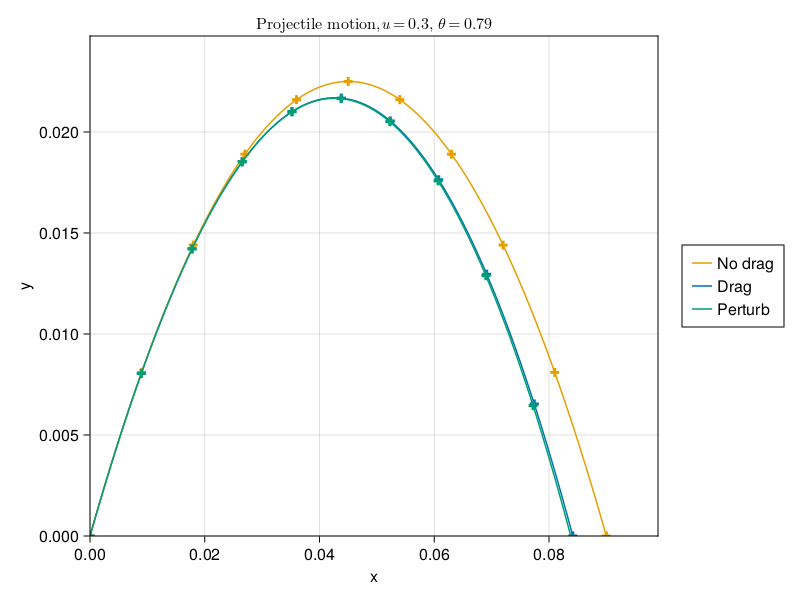

In [33]:
# Dimensional
ρ = 1.2 # kg m⁻³
r = 0.034 # m
Cd = 0.53
m = 0.058 # kg
g = 9.81 # ms⁻²
v_launch = 20 # ms⁻¹

# Terminal velocity

v₀ = let A = π * r * r
    sqrt(2 * m * g / (Cd * ρ * A))
end
# Launch velocity
u_launch = 0.3
# Launch angle
θ_launch = π/4
u_init = [u_launch*cos(θ_launch), u_launch*sin(θ_launch)]
γ_init = [0.0, 0.0, u_init...]
s_max =  2*u_init[2] 
sspan = (0, s_max)
saveat = s_max / 100
ss = range(sspan..., 101)
prob = ODEProblem(quadratic_drag, γ_init, sspan)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, saveat=saveat);
rxs = [a[1] for a in sol.u]
rys = [a[2] for a in sol.u];
rxs[argmin(abs.(rys[argmax(rys):end]))]
xs = rxs #* v₀^2 / g
ys = rys #* v₀^2 / g
ts = range(0, 4, length(xs)) #* v₀ / g

fig = Figure()
ax = Axis(fig[1, 1], xlabel="x", ylabel="y", title=L"\text{Projectile motion}, u=%$u_launch, \;\theta=%$(round(θ_launch; digits=2))", limits=(0, 1.1*nodragrange(θ_launch, u_launch), 0, 1.1*u_init[2]^2 / 2))
ln1 = lines!(ax, xs, ys)
scatter!(ax, xs[1:10:end], ys[1:10:end], marker=:+)

ndxs = [x₀(s, u_init)[1] for s in ss]
ndys = [x₀(s, u_init)[2] for s in ss]
ln2 = lines!(ax, ndxs, ndys)
scatter!(ax, ndxs[1:10:end], ndys[1:10:end], marker=:+)

prob = ODEProblem(perturb_1, [0, 0, 0, 0], sspan, (; v=u_init))
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, saveat=saveat);
rxs = [a[1] for a in sol.u] .+ ndxs
rys = [a[2] for a in sol.u] .+ ndys

ln3 = lines!(ax, rxs, rys)
scatter!(ax, rxs[1:10:end], rys[1:10:end], marker=:+)
Legend(fig[1, 2], [ln2, ln1, ln3], ["No drag", "Drag", "Perturb"])
fig

In [6]:
θs = range(0, π/2, 400)
us = range(0, 20, 400)
function maxrange(θ_launch, u_launch)
    # Launch velocity
    #u_launch = v_launch / v₀
    # Launch angle
    #θ_launch = π/4
    u_init = [0.0, 0.0, u_launch*cos(θ_launch), u_launch*sin(θ_launch)]
    sspan = (0, 4)

    prob = ODEProblem(quadratic_drag, u_init, sspan)
    sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, saveat=0.01);
    rxs = [a[1] for a in sol.u]
    rys = [a[2] for a in sol.u];
    rxs[argmin(abs.(rys[argmax(rys):end]))]
end

maxrange (generic function with 1 method)

In [7]:
nodragrange(θ, u) = u * u * sin(2θ)
nodragranges = [nodragrange(θ, u) for θ in θs, u in us];

In [8]:
ranges = [maxrange(θ, u) for θ in θs, u in us];
ranges_filt = imfilter(ranges, gaussian((2, 2)), "symmetric");

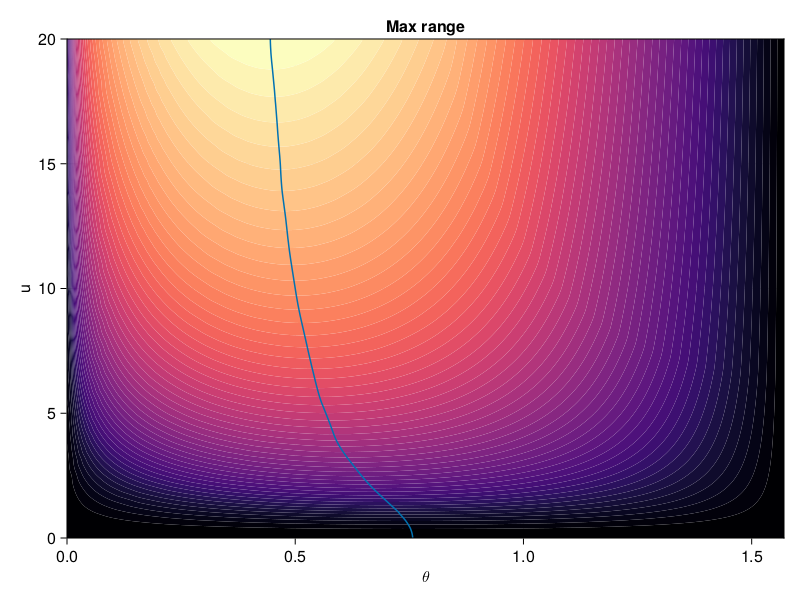

In [25]:
fig = Figure()
ax = Axis(fig[1, 1]; title="Max range", xlabel=L"\theta", ylabel="u")
contourf!(ax, θs, us, ranges_filt; levels=50, colorrange=(0, 1), colormap=:magma)
best_θ = θs[[a[1] for a in argmax(ranges_filt; dims=1)]][1, :]
lines!(ax, imfilter(best_θ, gaussian((10,)), "symmetric"), us)
fig

In [22]:
?imfilter

search:



```
imfilter([T], img, kernel, [border="replicate"], [alg]) --> imgfilt
imfilter([r], img, kernel, [border="replicate"], [alg]) --> imgfilt
imfilter(r, T, img, kernel, [border="replicate"], [alg]) --> imgfilt
```

Filter a one, two or multidimensional array `img` with a `kernel` by computing their correlation.

# Details

The term *filtering* emerges in the context of a Fourier transformation of an image, which maps an image from its canonical spatial domain to its concomitant frequency domain. Manipulating an image in the frequency domain amounts to retaining or discarding particular frequency components—a process analogous to sifting or filtering [1].  Because the Fourier transform establishes a link between the spatial and frequency representation of an image, one can interpret various image manipulations in the spatial domain as filtering operations which accept or reject specific frequencies.

The phrase *spatial filtering* is often used to emphasise that an operation is, at least conceptually, devised in the context of the spatial domain of an image. One further distinguishes between linear and non-linear spatial filtering. A filter is called linear if the operation performed on the pixels is linear, and is labeled non-linear otherwise.

An image filter can be represented by a function

$$
 w: \{s\in \mathbb{Z} \mid -k_1 \le s \le k_1  \} \times  \{t \in \mathbb{Z} \mid -k_2 \le t \le k_2  \}   \rightarrow \mathbb{R},
$$

where $k_i  \in \mathbb{N}$ (i = 1,2). It is common to define $k_1 = 2a+1$ and $k_2 = 2b + 1$, where $a$ and $b$ are integers, which ensures that the filter dimensions are of odd size. Typically, $k_1$ equals $k_2$ and so, dropping the subscripts, one speaks of a $k \times k$ filter. Since the domain of the filter represents a grid of spatial coordinates, the filter is often called a mask and is visualized as a grid. For example, a $3 \times 3$ mask can be potrayed as follows:

$$
\scriptsize
\begin{matrix}
\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(-1,-1) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}

&

\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(-1,0) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}
 &
\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(-1,1) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}
\\
\\
\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(0,-1) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}

&

\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(0,0) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}
 &
\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(0,1) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}
\\
\\
\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(1,-1) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}

&

\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(1,0) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}
 &
\boxed{
\begin{matrix}
\phantom{w(-9,-9)} \\
w(1,1) \\
\phantom{w(-9,-9)} \\
\end{matrix}
}
\end{matrix}.
$$

The values of $w(s,t)$ are referred to as *filter coefficients*.

## Discrete convolution versus correlation

There are two fundamental and closely related operations that one regularly performs on an image with a filter. The operations are called discrete *correlation* and *convolution*.

The correlation operation, denoted by the symbol $\star$,  is given in two dimensions by the expression

$$
\begin{aligned}
g(x,y) = w(x,y) \star f(x,y) = \sum_{s = -a}^{a} \sum_{t=-b}^{b} w(s,t) f(x+s, y+t),
\end{aligned}
$$

whereas the comparable convolution operation, denoted by the symbol $\ast$, is given in two dimensions by

$$
\begin{aligned}
h(x,y) = w(x,y) \ast f(x,y) = \sum_{s = -a}^{a} \sum_{t=-b}^{b} w(s,t) f(x-s, y-t).
\end{aligned}
$$

Since a digital image is of finite extent, both of these operations are undefined at the borders of the image. In particular, for an image of size $M \times N$, the function $f(x \pm s, y \pm t)$ is only defined for $1 \le x \pm s \le N$ and $1 \le y \pm t \le M$. In practice one addresses this problem by artificially expanding the domain of the image. For example, one can pad the image with zeros. Other padding strategies are possible, and they are discussed in more detail in the *Options* section of this documentation.

## One-dimensional illustration

The difference between correlation and convolution is best understood with recourse to a one-dimensional example  adapted from [1]. Suppose that a filter $w:\{-1,0,1\}\rightarrow \mathbb{R}$ has coefficients

$$
\begin{matrix}
\boxed{1} & \boxed{2} & \boxed{3}
\end{matrix}.
$$

Consider a discrete unit impulse function $f: \{x \in \mathbb{Z} \mid 1 \le x \le 7  \} \rightarrow \{0,1\}$  that has been padded with zeros. The function can be visualised as an image

$$
\boxed{
\begin{matrix}
0 & \boxed{0} & \boxed{0} & \boxed{0} & \boxed{1} & \boxed{0} & \boxed{0} & \boxed{0} & 0
\end{matrix}}.
$$

The correlation operation can be interpreted as sliding $w$ along the image and computing the sum of products at each location. For example,

$$
\begin{matrix}
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
1 & 2 & 3  &  & & & & & \\
& 1 & 2 & 3  &  & & & &  \\
& & 1 & 2 & 3  &  & & &  \\
& & & 1 & 2 & 3  &  & &  \\
& & & & 1 & 2 & 3  &  &  \\
& & & & & 1 & 2 & 3  &  \\
& & & & & & 1 & 2 & 3,
\end{matrix}
$$

yields the output $g: \{x \in \mathbb{Z} \mid 1 \le x \le 7  \} \rightarrow \mathbb{R}$, which when visualized as a digital image, is equal to

$$
\boxed{
\begin{matrix}
\boxed{0} & \boxed{0} & \boxed{3} & \boxed{2} & \boxed{1} & \boxed{0} & \boxed{0}
\end{matrix}}.
$$

The interpretation of the convolution operation is analogous to correlation, except that the filter $w$ has been rotated by 180 degrees. In particular,

$$
\begin{matrix}
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
3 & 2 & 1  &  & & & & & \\
& 3 & 2 & 1  &  & & & &  \\
& & 3 & 2 & 1  &  & & &  \\
& & & 3 & 2 & 1  &  & &  \\
& & & & 3 & 2 & 1  &  &  \\
& & & & & 3 & 2 & 1  &  \\
& & & & & & 3 & 2 & 1,
\end{matrix}
$$

yields the output $h: \{x \in \mathbb{Z} \mid 1 \le x \le 7  \} \rightarrow \mathbb{R}$ equal to

$$
\boxed{
\begin{matrix}
\boxed{0} & \boxed{0} & \boxed{1} & \boxed{2} & \boxed{3} & \boxed{0} & \boxed{0}
\end{matrix}}.
$$

Instead of rotating the filter mask, one could instead rotate $f$ and still obtained the same convolution result. In fact, the conventional notation for convolution indicates that $f$ is flipped and not $w$. If $w$ is symmetric, then convolution and correlation give the same outcome.

### Two-dimensional illustration

For a two-dimensional example, suppose the filter $w:\{-1, 0 ,1\} \times  \{-1,0,1\} \rightarrow \mathbb{R}$  has coefficients

$$
 \begin{matrix}
 \boxed{1} & \boxed{2} & \boxed{3} \\ \\
 \boxed{4} & \boxed{5} & \boxed{6} \\ \\
 \boxed{7} & \boxed{8} & \boxed{9}
 \end{matrix},
$$

and consider a two-dimensional discrete unit impulse function

$$
 f:\{x \in \mathbb{Z} \mid 1 \le x \le 7  \} \times  \{y \in \mathbb{Z} \mid 1 \le y \le 7  \}\rightarrow \{ 0,1\}
$$

that has been padded with zeros:

$$
 \boxed{
 \begin{matrix}
   0 &        0  &        0  &        0   &        0  &        0  &   0  \\ \\
   0 & \boxed{0} & \boxed{0} & \boxed{0}  & \boxed{0} & \boxed{0} &   0  \\ \\
   0 & \boxed{0} & \boxed{0} & \boxed{0}  & \boxed{0} & \boxed{0} &   0 \\ \\
   0 & \boxed{0} & \boxed{0} & \boxed{1}  & \boxed{0} & \boxed{0} &   0 \\ \\
   0 & \boxed{0} & \boxed{0} & \boxed{0}  & \boxed{0} & \boxed{0} &   0 \\ \\
   0 & \boxed{0} & \boxed{0} & \boxed{0}  & \boxed{0} & \boxed{0} &   0 \\ \\
   0 &        0  &        0  &        0   &        0  &        0  &   0
 \end{matrix}}.
$$

The correlation operation $w(x,y) \star f(x,y)$  yields the output

$$
 \boxed{
 \begin{matrix}
 \boxed{0} & \boxed{0}  & \boxed{0} & \boxed{0} & \boxed{0} \\ \\
 \boxed{0} &  \boxed{9} & \boxed{8} & \boxed{7} & \boxed{0} \\ \\
 \boxed{0} &  \boxed{6} & \boxed{5} & \boxed{4} & \boxed{0} \\ \\
 \boxed{0} &  \boxed{3} & \boxed{2} & \boxed{1} & \boxed{0} \\ \\
 \boxed{0} & \boxed{0}  & \boxed{0} & \boxed{0} & \boxed{0}
 \end{matrix}},
$$

whereas the convolution operation $w(x,y) \ast f(x,y)$ produces

$$
 \boxed{
 \begin{matrix}
 \boxed{0} & \boxed{0} & \boxed{0} & \boxed{0} & \boxed{0} \\ \\
 \boxed{0} & \boxed{1} & \boxed{2} & \boxed{3} & \boxed{0}\\ \\
 \boxed{0} & \boxed{4} & \boxed{5} & \boxed{6} & \boxed{0} \\ \\
 \boxed{0} & \boxed{7} & \boxed{8} & \boxed{9} & \boxed{0} \\ \\
 \boxed{0} & \boxed{0} & \boxed{0} & \boxed{0} & \boxed{0}
 \end{matrix}}.
$$

## Discrete convolution and correlation as matrix multiplication

Discrete convolution and correlation operations can also be formulated as a matrix multiplication, where one of the inputs is converted to a [Toeplitz](https://en.wikipedia.org/wiki/Toeplitz_matrix) matrix, and the other is represented as a column vector. For example, consider a function $f:\{x \in \mathbb{N} \mid 1 \le x \le M \} \rightarrow \mathbb{R}$ and a filter $w: \{s \in \mathbb{N} \mid  -k_1 \le s \le k_1  \} \rightarrow \mathbb{R}$. Then the matrix multiplication

$$
\begin{bmatrix}
w(-k_1) 	&  0	    & \ldots	& 0		   & 0			\\
\vdots 	& w(-k_1) 	& \ldots	& \vdots  & 0	        \\
w(k_1) 	    & \vdots   & \ldots	& 0		   & \vdots    \\
0 	    	& w(k_1)	& \ldots   & w(-k_1)  & 0		    \\
0 	        & 0		    & \ldots	& \vdots  & w(-k_1)	\\
\vdots     & \vdots	& \ldots	& w(k_1)   & \vdots	\\
0           & 0         & 0			& 0		   & w(k_1)
\end{bmatrix}
\begin{bmatrix}
f(1) \\
f(2) \\
f(3) \\
\vdots \\
f(M)
\end{bmatrix}
$$

is equivalent to the convolution $w(s) \ast f(x)$ assuming that the border of $f(x)$ has been padded with zeros.

To represent multidimensional convolution as matrix multiplication one reshapes the multidimensional arrays into column vectors and proceeds in an analogous manner. Naturally, the result of the matrix multiplication will need to be reshaped into an appropriate multidimensional array.

# Options

The following subsections describe valid options for the function arguments in more detail.

## Choices for `r`

You can dispatch to different implementations by passing in a resource `r` as defined by the [ComputationalResources](https://github.com/timholy/ComputationalResources.jl) package. For example,

```julia
    imfilter(ArrayFireLibs(), img, kernel)
```

would request that the computation be performed on the GPU using the ArrayFire libraries.

## Choices for `T`

Optionally, you can control the element type of the output image by passing in a type `T` as the first argument.

## Choices for `img`

You can specify a one, two or multidimensional array defining your image.

## Choices for `kernel`

The `kernel[0,0,..]` parameter corresponds to the origin (zero displacement) of the kernel; you can use `centered` to place the origin at the array center, or use the OffsetArrays package to set `kernel`'s indices manually. For example, to filter with a random *centered* 3x3 kernel, you could use either of the following:

```
kernel = centered(rand(3,3))
kernel = OffsetArray(rand(3,3), -1:1, -1:1)
```

The `kernel` parameter can be specified as an array or as a "factored kernel", a tuple `(filt1, filt2, ...)` of filters to apply along each axis of the image. In cases where you know your kernel is separable, this format can speed processing. Each of these should have the same dimensionality as the image itself, and be shaped in a manner that indicates the filtering axis, e.g., a 3x1 filter for filtering the first dimension and a 1x3 filter for filtering the second dimension. In two dimensions, any kernel passed as a single matrix is checked for separability; if you want to eliminate that check, pass the kernel as a single-element tuple, `(kernel,)`.

## Choices for `border`

At the image edge, `border` is used to specify the padding which will be used to extrapolate the image beyond its original bounds. As an indicative example of each option the results of the padding are illustrated on an image consisting of a row of six pixels which are specified alphabetically: $\boxed{a \, b \, c \, d \, e \, f}$. We show the effects of padding only on the left and right border, but analogous consequences hold for the top and bottom border.

### `"replicate"` (default)

The border pixels extend beyond the image boundaries.

$$
\boxed{
\begin{array}{l|c|r}
  a\, a\, a\, a  &  a \, b \, c \, d \, e \, f & f \, f \, f \, f
\end{array}
}
$$

See also: [`Pad`](@ref), [`padarray`](@ref), [`Inner`](@ref), [`NA`](@ref)  and [`NoPad`](@ref)

### `"circular"`

The border pixels wrap around. For instance, indexing beyond the left border returns values starting from the right border.

$$
\boxed{
\begin{array}{l|c|r}
  c\, d\, e\, f  &  a \, b \, c \, d \, e \, f & a \, b \, c \, d
\end{array}
}
$$

See also: [`Pad`](@ref), [`padarray`](@ref), [`Inner`](@ref), [`NA`](@ref)  and [`NoPad`](@ref)

### `"reflect"`

The border pixels reflect relative to a position between pixels. That is, the border pixel is omitted when mirroring.

$$
\boxed{
\begin{array}{l|c|r}
  e\, d\, c\, b  &  a \, b \, c \, d \, e \, f & e \, d \, c \, b
\end{array}
}
$$

See also: [`Pad`](@ref), [`padarray`](@ref), [`Inner`](@ref), [`NA`](@ref)  and [`NoPad`](@ref)

### `"symmetric"`

The border pixels reflect relative to the edge itself.

$$
\boxed{
\begin{array}{l|c|r}
  d\, c\, b\, a  &  a \, b \, c \, d \, e \, f & f \, e \, d \, c
\end{array}
}
$$

See also: [`Pad`](@ref), [`padarray`](@ref), [`Inner`](@ref), [`NA`](@ref)  and [`NoPad`](@ref)

### `Fill(m)`

The border pixels are filled with a specified value $m$.

$$
\boxed{
\begin{array}{l|c|r}
  m\, m\, m\, m  &  a \, b \, c \, d \, e \, f & m \, m \, m \, m
\end{array}
}
$$

See also: [`Pad`](@ref), [`padarray`](@ref), [`Inner`](@ref), [`NA`](@ref)  and [`NoPad`](@ref)

### `Inner()`

Indicate that edges are to be discarded in filtering, only the interior of the result is to be returned.

See also: [`Pad`](@ref), [`padarray`](@ref), [`Inner`](@ref), [`NA`](@ref)  and [`NoPad`](@ref)

### `NA()`

Choose filtering using "NA" (Not Available) boundary conditions. This is most appropriate for filters that have only positive weights, such as blurring filters.

See also: [`Pad`](@ref), [`padarray`](@ref), [`Inner`](@ref), [`NA`](@ref)  and [`NoPad`](@ref)

## Choices for `alg`

The `alg` parameter allows you to choose the particular algorithm: `Algorithm.FIR()` (finite impulse response, aka traditional digital filtering) or `Algorithm.FFT()` (Fourier-based filtering). If no choice is specified, one will be chosen based on the size of the image and kernel in a way that strives to deliver good performance. Alternatively you can use a custom filter type, like [`KernelFactors.IIRGaussian`](@ref).

# Examples

The following subsections highlight some common use cases.

## Convolution versus correlation

```julia

# Create a two-dimensional discrete unit impulse function.
f = fill(0,(9,9));
f[5,5] = 1;

# Specify a filter coefficient mask and set the center of the mask as the origin.
w = centered([1 2 3; 4 5 6 ; 7 8 9]);

#=
 The default operation of `imfilter` is correlation.  By reflecting `w` we
 compute the convolution of `f` and `w`.  `Fill(0,w)` indicates that we wish to
 pad the border of `f` with zeros. The amount of padding is automatically
 determined by considering the length of w.
=#
correlation = imfilter(f,w,Fill(0,w))
convolution = imfilter(f,reflect(w),Fill(0,w))

```

## Miscellaneous border padding options

```julia
# Example function values f, and filter coefficients w.
f = reshape(1.0:81.0,9,9)
w = centered(reshape(1.0:9.0,3,3))

# You can designate the type of padding by specifying an appropriate string.
imfilter(f,w,"replicate")
imfilter(f,w,"circular")
imfilter(f,w,"symmetric")
imfilter(f,w,"reflect")

# Alternatively, you can explicitly use the Pad type to designate the padding style.
imfilter(f,w,Pad(:replicate))
imfilter(f,w,Pad(:circular))
imfilter(f,w,Pad(:symmetric))
imfilter(f,w,Pad(:reflect))

# If you want to pad with a specific value then use the Fill type.
imfilter(f,w,Fill(0,w))
imfilter(f,w,Fill(1,w))
imfilter(f,w,Fill(-1,w))

#=
  Specify 'Inner()' if you want to retrieve the interior sub-array of f for which
  the filtering operation is defined without padding.
=#
imfilter(f,w,Inner())
```

# References

1. R. C. Gonzalez and R. E. Woods. *Digital Image Processing (3rd Edition)*.  Upper Saddle River, NJ, USA: Prentice-Hall,  2006.

See also: [`imfilter!`](@ref), [`centered`](@ref OffsetArrays.centered), [`padarray`](@ref), [`Pad`](@ref), [`Fill`](@ref), [`Inner`](@ref), [`KernelFactors.IIRGaussian`](@ref).
